# Clasificación Binaria de Attrition de clientes Piloto en Bengala para cliente MoneyRocks

# Librerias

In [1]:
# general
import numpy as np
import pandas as pd
import re
import os
import joblib
import pandas as pd
import random
import scipy.stats as stats
import pylab
import itertools

# funciones
from funciones.data_exploration import explore
from funciones.feature_cleaning import missing_data, outlier, rare_values
from funciones.feature_cleaning import missing_data as ms
from funciones.feature_cleaning import outlier as ot
from funciones.feature_cleaning import rare_values as ra
from funciones.feature_engineering import discretization as dc
from funciones.feature_engineering import discretization, encoding, transformation
from funciones.feature_selection import embedded_method, feature_shuffle, filter_method, hybrid


# visualización
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import warn
from pandas.plotting import scatter_matrix
plt.style.use('seaborn-colorblind')
#from data_exploration import explore


# preprocesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder


# Aprendizaje No Supervisado
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, FactorAnalysis
from sklearn.cluster import KMeans, SpectralClustering, Birch, BisectingKMeans
from sklearn.manifold import TSNE, Isomap
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis


# ML sklearn
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
import xgboost
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier, LGBMModel
from catboost import CatBoostClassifier


# metricas de evaluacion
from sklearn.metrics import make_scorer, confusion_matrix  # matriz de confusion 
from sklearn.metrics import classification_report # reporte de clasificación

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # clasificación binaria
from sklearn.metrics import average_precision_score

from sklearn.metrics import balanced_accuracy_score, auc, roc_curve, roc_auc_score, RocCurveDisplay # clasificación multi-class
from sklearn.metrics import cohen_kappa_score, hinge_loss, matthews_corrcoef, top_k_accuracy_score


# autoML H2O
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch


# ML pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel

# interpretacion
from sklearn import set_config
import shap

C:\Users\Diego\AppData\Local\Temp\ipykernel_17460\1833377063.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Bases de datos

In [3]:
# cargar bases de datos
data = pd.read_excel('data/AbandonoTC.xlsx')
data

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0      768805383  Existing Customer            45      M                3   
1      818770008  Existing Customer            49      F                5   
2      713982108  Existing Customer            51      M                3   
3      769911858  Existing Customer            40      F                4   
4      709106358  Existing Customer            40      M                3   
...          ...                ...           ...    ...              ...   
10122  772366833  Existing Customer            50      M                2   
10123  710638233  Attrited Customer            41      M                2   
10124  716506083  Attrited Customer            44      F                1   
10125  717406983  Attrited Customer            30      M                2   
10126  714337233  Attrited Customer            43      F                2   

      Education_Level Marital_Status Income_Category Card_Category  \
0         High School        Married     $60K - $80K          Blue   
1            Graduate         Single  Less than $40K          Blue   
2            Graduate        Married    $80K - $120K          Blue   
3         High School        Unknown  Less than $40K          Blue   
4          Uneducated        Married     $60K - $80K          Blue   
...               ...            ...             ...           ...   
10122        Graduate         Single     $40K - $60K          Blue   
10123         Unknown       Divorced     $40K - $60K          Blue   
10124     High School        Married  Less than $40K          Blue   
10125        Graduate        Unknown     $40K - $60K          Blue   
10126        Graduate        Married  Less than $40K        Silver   

       Months_on_book  ...  Contacts_Count_12_mon  Credit_Limit  \
0                  39  ...                      3       12691.0   
1                  44  ...                      2        8256.0   
2                  36  ...                      0        3418.0   
3                  34  ...                      1        3313.0   
4                  21  ...                      0        4716.0   
...               ...  ...                    ...           ...   
10122              40  ...                      3        4003.0   
10123              25  ...                      3        4277.0   
10124              36  ...                      4        5409.0   
10125              36  ...                      3        5281.0   
10126              25  ...                      4       10388.0   

       Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                      777          11914.0                 1.335   
1                      864           7392.0                 1.541   
2                        0           3418.0                 2.594   
3                     2517            796.0                 1.405   
4                        0           4716.0                 2.175   
...                    ...              ...                   ...   
10122                 1851           2152.0                 0.703   
10123                 2186           2091.0                 0.804   
10124                    0           5409.0                 0.819   
10125                    0           5281.0                 0.535   
10126                 1961           8427.0                 0.703   

       Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1144              42                1.625   
1                 1291              33                3.714   
2                 1887              20                2.333   
3                 1171              20                2.333   
4                  816              28                2.500   
...                ...             ...                  ...   
10122            15476             117                0.857   
10123             8764              69                0.683   
10124            10291              60  

In [128]:
data.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'],
      dtype='object')

# Preprocesamiento

## Limpieza de datos

In [129]:
# calcular porcentaje de missing values y NULLs en cada columna
porcentaje_missing = data.isna().mean() * 100
porcentaje_null = data.isna().mean() * 100

# Sort the variables by missing percentage in descending order
porcentaje_missing.sort_values(ascending=False, inplace=True)
porcentaje_null.sort_values(ascending=False, inplace=True)

# ver variables por porcentaje de NA/NULL
print('porcentaje missing NA',porcentaje_missing)
print('porcentaje NULL NULL',porcentaje_null)

# NO hay NA/NULL

porcentaje missing NA CLIENTNUM                                                                                                                             0.0
Attrition_Flag                                                                                                                        0.0
Avg_Utilization_Ratio                                                                                                                 0.0
Total_Ct_Chng_Q4_Q1                                                                                                                   0.0
Total_Trans_Ct                                                                                                                        0.0
Total_Trans_Amt                                                                                                                       0.0
Total_Amt_Chng_Q4_Q1                                                                                                                  0.0
Avg_Open_To_

In [130]:
# extraer tipos de variables
numeric_columns = data.select_dtypes(include=['float16', 'float32','float64'])
integer_columns = data.select_dtypes(include=['int8', 'int16', 'int32', 'int64'])
categorical_columns = data.select_dtypes(include=['object'])

data_num = data.select_dtypes(exclude=['object'])
data_cate = data.select_dtypes(include=['object'])

In [131]:
integer_columns

CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
0      768805383            45                3              39   
1      818770008            49                5              44   
2      713982108            51                3              36   
3      769911858            40                4              34   
4      709106358            40                3              21   
...          ...           ...              ...             ...   
10122  772366833            50                2              40   
10123  710638233            41                2              25   
10124  716506083            44                1              36   
10125  717406983            30                2              36   
10126  714337233            43                2              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                             4                       1   
3                             3                       4   
4                             5                       1   
...                         ...                     ...   
10122                         3                       2   
10123                         4                       2   
10124                         5                       3   
10125                         4                       3   
10126                         6                       2   

       Contacts_Count_12_mon  Total_Revolving_Bal  Total_Trans_Amt  \
0                          3                  777             1144   
1                          2                  864             1291   
2                          0                    0             1887   
3                          1                 2517             1171   
4                          0                    0              816   
...                      ...                  ...              ...   
10122                      3                 1851            15476   
10123                      3                 2186             8764   
10124                      4                    0            10291   
10125                      3                    0             8395   
10126                      4                 1961            10294   

       Total_Trans_Ct  
0                  42  
1                  33  
2                  20  
3                  20  
4                  28  
...               ...  
10122             117  
10123              69  
10124              60  
10125              62  
10126              61  

[10127 rows x 10 columns]

In [132]:
numeric_columns

Credit_Limit  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0           12691.0          11914.0                 1.335   
1            8256.0           7392.0                 1.541   
2            3418.0           3418.0                 2.594   
3            3313.0            796.0                 1.405   
4            4716.0           4716.0                 2.175   
...             ...              ...                   ...   
10122        4003.0           2152.0                 0.703   
10123        4277.0           2091.0                 0.804   
10124        5409.0           5409.0                 0.819   
10125        5281.0           5281.0                 0.535   
10126       10388.0           8427.0                 0.703   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  \
0                    1.625                  0.061   
1                    3.714                  0.105   
2                    2.333                  0.000   
3                    2.333                  0.760   
4                    2.500                  0.000   
...                    ...                    ...   
10122                0.857                  0.462   
10123                0.683                  0.511   
10124                0.818                  0.000   
10125                0.722                  0.000   
10126                0.649                  0.189   

       Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  
0                                               0.000093                                                                                   
1                                               0.000057                                                                                   
2                                               0.000021                                                                                   
3                                               0.000134                                                                                   
4                                               0.000022                                                                                   
...                                                  ...                                                                                   
10122                                           0.000191                                                                                   
10123                                           0.995270                                                                                   
10124                                           0.997880                                                                                   
10125                                           0.996710                                                                                   
10126                                           0.996620                                                                                   

[10127 rows x 6 columns]

In [133]:
categorical_columns

# quitar y-target de columnas categoricas
categorical_columns = categorical_columns.drop(columns='Attrition_Flag')

In [134]:
categorical_columns

Gender Education_Level Marital_Status Income_Category Card_Category
0          M     High School        Married     $60K - $80K          Blue
1          F        Graduate         Single  Less than $40K          Blue
2          M        Graduate        Married    $80K - $120K          Blue
3          F     High School        Unknown  Less than $40K          Blue
4          M      Uneducated        Married     $60K - $80K          Blue
...      ...             ...            ...             ...           ...
10122      M        Graduate         Single     $40K - $60K          Blue
10123      M         Unknown       Divorced     $40K - $60K          Blue
10124      F     High School        Married  Less than $40K          Blue
10125      M        Graduate        Unknown     $40K - $60K          Blue
10126      F        Graduate        Married  Less than $40K        Silver

[10127 rows x 5 columns]

## Crear variables y-target para clasificación multi-clase

In [135]:
x = data.drop(['Attrition_Flag'], axis=1)
y = data['Attrition_Flag']

In [136]:
x

CLIENTNUM  Customer_Age Gender  Dependent_count Education_Level  \
0      768805383            45      M                3     High School   
1      818770008            49      F                5        Graduate   
2      713982108            51      M                3        Graduate   
3      769911858            40      F                4     High School   
4      709106358            40      M                3      Uneducated   
...          ...           ...    ...              ...             ...   
10122  772366833            50      M                2        Graduate   
10123  710638233            41      M                2         Unknown   
10124  716506083            44      F                1     High School   
10125  717406983            30      M                2        Graduate   
10126  714337233            43      F                2        Graduate   

      Marital_Status Income_Category Card_Category  Months_on_book  \
0            Married     $60K - $80K          Blue              39   
1             Single  Less than $40K          Blue              44   
2            Married    $80K - $120K          Blue              36   
3            Unknown  Less than $40K          Blue              34   
4            Married     $60K - $80K          Blue              21   
...              ...             ...           ...             ...   
10122         Single     $40K - $60K          Blue              40   
10123       Divorced     $40K - $60K          Blue              25   
10124        Married  Less than $40K          Blue              36   
10125        Unknown     $40K - $60K          Blue              36   
10126        Married  Less than $40K        Silver              25   

       Total_Relationship_Count  ...  Contacts_Count_12_mon  Credit_Limit  \
0                             5  ...                      3       12691.0   
1                             6  ...                      2        8256.0   
2                             4  ...                      0        3418.0   
3                             3  ...                      1        3313.0   
4                             5  ...                      0        4716.0   
...                         ...  ...                    ...           ...   
10122                         3  ...                      3        4003.0   
10123                         4  ...                      3        4277.0   
10124                         5  ...                      4        5409.0   
10125                         4  ...                      3        5281.0   
10126                         6  ...                      4       10388.0   

       Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                      777          11914.0                 1.335   
1                      864           7392.0                 1.541   
2                        0           3418.0                 2.594   
3                     2517            796.0                 1.405   
4                        0           4716.0                 2.175   
...                    ...              ...                   ...   
10122                 1851           2152.0                 0.703   
10123                 2186           2091.0                 0.804   
10124                    0           5409.0                 0.819   
10125                    0           5281.0                 0.535   
10126                 1961           8427.0                 0.703   

       Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1144              42                1.625   
1                 1291              33                3.714   
2                 1887              20                2.333   
3                 1171              20                2.333   
4                  816              28                2.500   
...                ...             ...                  ...   
10122            15476             117                0.857   
10123             8

In [137]:
y.value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

## Dividir base de datos en datos de entrenamiento y datos de prueba

In [138]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify=y)

In [139]:
x_train

CLIENTNUM  Customer_Age Gender  Dependent_count Education_Level  \
9500   788908308            46      M                2     High School   
8586   713916708            53      M                3        Graduate   
7391   713736333            41      F                3      Uneducated   
6822   717255333            40      M                3        Graduate   
2707   735008958            42      M                5         Unknown   
...          ...           ...    ...              ...             ...   
509    716223708            45      F                3      Uneducated   
1458   714573258            36      M                2   Post-Graduate   
9509   787723758            58      F                3         Unknown   
6113   720049083            35      F                1         Unknown   
10034  714544908            56      M                4        Graduate   

      Marital_Status Income_Category Card_Category  Months_on_book  \
9500          Single     $40K - $60K          Blue              32   
8586          Single         $120K +          Gold              43   
7391         Married     $40K - $60K          Blue              36   
6822          Single    $80K - $120K          Blue              36   
2707         Married     $60K - $80K          Blue              35   
...              ...             ...           ...             ...   
509           Single         Unknown          Blue              36   
1458          Single     $60K - $80K          Blue              30   
9509         Married  Less than $40K          Blue              48   
6113        Divorced         Unknown          Blue              24   
10034       Divorced     $60K - $80K          Blue              36   

       Total_Relationship_Count  ...  Contacts_Count_12_mon  Credit_Limit  \
9500                          2  ...                      2        5972.0   
8586                          3  ...                      3       34516.0   
7391                          1  ...                      4        3606.0   
6822                          1  ...                      2        6921.0   
2707                          6  ...                      2       13650.0   
...                         ...  ...                    ...           ...   
509                           3  ...                      3        4028.0   
1458                          4  ...                      4        1606.0   
9509                          2  ...                      2        3603.0   
6113                          5  ...                      3        1438.3   
10034                         6  ...                      3        6224.0   

       Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
9500                     0           5972.0                 0.606   
8586                  2435          32081.0                 0.770   
7391                     0           3606.0                 0.370   
6822                     0           6921.0                 0.824   
2707                  1253          12397.0                 0.743   
...                    ...              ...                   ...   
509                    710           3318.0                 0.731   
1458                   798            808.0                 0.590   
9509                  1465           2138.0                 0.630   
6113                     0           1438.3                 0.849   
10034                    0           6224.0                 0.920   

       Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
9500             14227             116                0.706   
8586              7758              98                0.719   
7391              1829              41                0.519   
6822              2729              44                0.467   
2707              1703              53                0.710   
...                ...             ...                  ...   
509                791              22                0.833   
1458              2

In [140]:
y_train

9500     Existing Customer
8586     Existing Customer
7391     Attrited Customer
6822     Attrited Customer
2707     Existing Customer
               ...        
509      Attrited Customer
1458     Existing Customer
9509     Existing Customer
6113     Attrited Customer
10034    Attrited Customer
Name: Attrition_Flag, Length: 8101, dtype: object

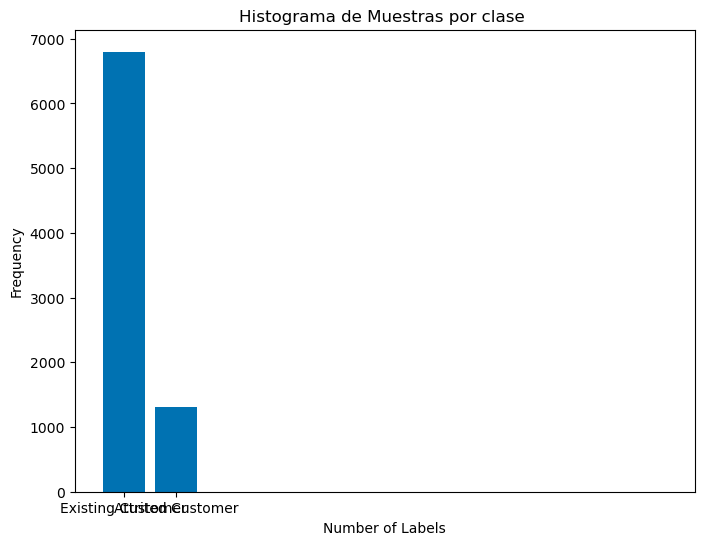

In [141]:
# Histogram
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins=range(12), align='left', rwidth=0.8)
plt.xlabel('Number of Labels')
plt.ylabel('Frequency')
plt.title('Histograma de Muestras por clase ')
plt.show()

## Codificación

In [142]:
categorical_columns

Gender Education_Level Marital_Status Income_Category Card_Category
0          M     High School        Married     $60K - $80K          Blue
1          F        Graduate         Single  Less than $40K          Blue
2          M        Graduate        Married    $80K - $120K          Blue
3          F     High School        Unknown  Less than $40K          Blue
4          M      Uneducated        Married     $60K - $80K          Blue
...      ...             ...            ...             ...           ...
10122      M        Graduate         Single     $40K - $60K          Blue
10123      M         Unknown       Divorced     $40K - $60K          Blue
10124      F     High School        Married  Less than $40K          Blue
10125      M        Graduate        Unknown     $40K - $60K          Blue
10126      F        Graduate        Married  Less than $40K        Silver

[10127 rows x 5 columns]

In [143]:
# one-hot encoding [0-1]
x_train = pd.get_dummies(x_train, drop_first=True, columns=categorical_columns.columns)
x_test = pd.get_dummies(x_test, drop_first=True, columns=categorical_columns.columns)


In [144]:
x_train

CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
9500   788908308            46                2              32   
8586   713916708            53                3              43   
7391   713736333            41                3              36   
6822   717255333            40                3              36   
2707   735008958            42                5              35   
...          ...           ...              ...             ...   
509    716223708            45                3              36   
1458   714573258            36                2              30   
9509   787723758            58                3              48   
6113   720049083            35                1              24   
10034  714544908            56                4              36   

       Total_Relationship_Count  Months_Inactive_12_mon  \
9500                          2                       3   
8586                          3                       1   
7391                          1                       3   
6822                          1                       2   
2707                          6                       3   
...                         ...                     ...   
509                           3                       3   
1458                          4                       2   
9509                          2                       1   
6113                          5                       3   
10034                         6                       3   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
9500                       2        5972.0                    0   
8586                       3       34516.0                 2435   
7391                       4        3606.0                    0   
6822                       2        6921.0                    0   
2707                       2       13650.0                 1253   
...                      ...           ...                  ...   
509                        3        4028.0                  710   
1458                       4        1606.0                  798   
9509                       2        3603.0                 1465   
6113                       3        1438.3                    0   
10034                      3        6224.0                    0   

       Avg_Open_To_Buy  ...  Marital_Status_Single  Marital_Status_Unknown  \
9500            5972.0  ...                      1                       0   
8586           32081.0  ...                      1                       0   
7391            3606.0  ...                      0                       0   
6822            6921.0  ...                      1                       0   
2707           12397.0  ...                      0                       0   
...                ...  ...                    ...                     ...   
509             3318.0  ...                      1                       0   
1458             808.0  ...                      1                       0   
9509            2138.0  ...                      0                       0   
6113            1438.3  ...                      0                       0   
10034           6224.0  ...                      0                       0   

       Income_Category_$40K - $60K  Income_Category_$60K - $80K  \
9500                             1                            0   
8586                             0                            0   
7391                             1                            0   
6822                             0                            0   
2707                             0                            1   
...                            ...                          ...   
509                              0                            0   
1458                             0                            1   
9509                             0                            0   
6113                             0                            0   
10034         

In [145]:
x_test

CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
7876   708761733            52                3              36   
7092   771433608            54                4              42   
10011  710122458            38                2              36   
9664   709910733            49                4              30   
9295   719324658            27                0              19   
...          ...           ...              ...             ...   
3402   710809833            40                3              27   
2006   789167658            34                3              23   
2797   755399433            43                3              36   
8309   781073733            50                2              41   
8334   715773783            44                2              35   

       Total_Relationship_Count  Months_Inactive_12_mon  \
7876                          2                       2   
7092                          5                       2   
10011                         5                       3   
9664                          2                       3   
9295                          1                       1   
...                         ...                     ...   
3402                          3                       1   
2006                          5                       3   
2797                          6                       1   
8309                          1                       3   
8334                          2                       3   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
7876                       2        8279.0                 1582   
7092                       2       11742.0                    0   
10011                      2       31546.0                 2057   
9664                       2       34516.0                 1963   
9295                       3       34516.0                 1131   
...                      ...           ...                  ...   
3402                       2       34516.0                    0   
2006                       2        4245.0                 1815   
2797                       2       28634.0                  926   
8309                       3        4607.0                    0   
8334                       4        4196.0                  561   

       Avg_Open_To_Buy  ...  Marital_Status_Single  Marital_Status_Unknown  \
7876            6697.0  ...                      0                       0   
7092           11742.0  ...                      1                       0   
10011          29489.0  ...                      1                       0   
9664           32553.0  ...                      1                       0   
9295           33385.0  ...                      0                       1   
...                ...  ...                    ...                     ...   
3402           34516.0  ...                      0                       0   
2006            2430.0  ...                      0                       0   
2797           27708.0  ...                      0                       0   
8309            4607.0  ...                      0                       0   
8334            3635.0  ...                      1                       0   

       Income_Category_$40K - $60K  Income_Category_$60K - $80K  \
7876                             0                            0   
7092                             0                            0   
10011                            0                            1   
9664                             0                            0   
9295                             0                            0   
...                            ...                          ...   
3402                             0                            0   
2006                             0                            1   
2797                             0                            0   
8309                             0                            0   
8334          

## Estandarización

In [146]:
num_columns = pd.concat([integer_columns, numeric_columns])
num = num_columns.columns.tolist()
num

['CLIENTNUM',
 'Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Revolving_Bal',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Credit_Limit',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1']

In [148]:
# crear escalador Estandar
escalador = StandardScaler()

# ajustar escalador con datos de entrenamiento (variables numericas)
escalador.fit(x_train[num])
escalador


StandardScaler()

In [149]:
# estandarizar datos de entrenamiento y prueba
x_train[num] = escalador.transform(x_train[num])
x_test[num] = escalador.transform(x_test[num])

## Guardar bases de datos

In [150]:
# guardar bases de datos
# datos de entrenamiento
x_train.to_csv('data/finvivir/x_trainpreprocess.csv', index=False)
y_train.to_csv('data/finvivir/y_trainpreprocess.csv', index=False)

# datos de prueba
x_test.to_csv('data/finvivir/x_testpreprocess.csv', index=False)
y_test.to_csv('data/finvivir/y_testpreprocess.csv', index=False)

# EDA

In [59]:
# cargar datos de entrenamiento 
x_train = pd.read_csv('data/finvivir/x_trainpreprocess.csv')
y_train = pd.read_csv('data/finvivir/y_trainpreprocess.csv')

# cargar datos de prueba
x_test = pd.read_csv('data/finvivir/x_testpreprocess.csv')
y_test = pd.read_csv('data/finvivir/y_testpreprocess.csv')

In [60]:
# crear base de datos de entrenamiento full
full_train1 = x_train.copy()
full_train1['y_target'] = y_train
full_train1

CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
0      1.364875     -0.043596        -0.260188       -0.490956   
1     -0.677773      0.825980         0.505165        0.881967   
2     -0.682686     -0.664722         0.505165        0.008289   
3     -0.586834     -0.788948         0.505165        0.008289   
4     -0.103255     -0.540497         2.035872       -0.116522   
...         ...           ...              ...             ...   
8096  -0.614934     -0.167821         0.505165        0.008289   
8097  -0.659889     -1.285848        -0.260188       -0.740578   
8098   1.332610      1.447107         0.505165        1.506023   
8099  -0.510737     -1.410074        -1.025542       -1.489445   
8100  -0.660662      1.198656         1.270519        0.008289   

      Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                    -1.166725                0.664344              -0.413463   
1                    -0.522529               -1.328196               0.492042   
2                    -1.810921                0.664344               1.397547   
3                    -1.810921               -0.331926              -0.413463   
4                     1.410058                0.664344              -0.413463   
...                        ...                     ...                    ...   
8096                 -0.522529                0.664344               0.492042   
8097                  0.121666               -0.331926               1.397547   
8098                 -1.166725               -1.328196              -0.413463   
8099                  0.765862                0.664344               0.492042   
8100                  1.410058                0.664344               0.492042   

      Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  ...  \
0        -0.291946            -1.413872        -0.164462  ...   
1         2.852836             1.563818         2.710240  ...   
2        -0.552616            -1.413872        -0.424967  ...   
3        -0.187392            -1.413872        -0.059973  ...   
4         0.553963             0.118385         0.542956  ...   
...            ...                  ...              ...  ...   
8096     -0.506123            -0.545634        -0.456677  ...   
8097     -0.772962            -0.438022        -0.733038  ...   
8098     -0.552947             0.377633        -0.586600  ...   
8099     -0.791438            -1.413872        -0.663640  ...   
8100     -0.264183            -1.413872        -0.136716  ...   

      Marital_Status_Unknown  Income_Category_$40K - $60K  \
0                          0                            1   
1                          0                            0   
2                          0                            1   
3                          0                            0   
4                          0                            0   
...                      ...                          ...   
8096                       0                            0   
8097                       0                            0   
8098                       0                            0   
8099                       0                            0   
8100                       0                            0   

      Income_Category_$60K - $80K  Income_Category_$80K - $120K  \
0                               0                             0   
1                               0                             0   
2                               0                             0   
3                               0                             1   
4                               1                             0   
...                           ...                           ...   
8096                            0                             0   
8097                            1                             0   
8098                            0                             0   
8099                            0                       

In [61]:
# cambiar nombre de variable clasificador Naive Bayes
full_train1.rename(columns={'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1':'NBClassifier'}, inplace=True)


In [63]:
def encode_binary_column(df, column_name):
  label_map = {"Existing Customer": 0, "Attrited Customer": 1}  # Replace with your actual binary values
  df[column_name] = df[column_name].map(label_map)
  return df

In [64]:
full_train1 = encode_binary_column(full_train1.copy(), "y_target")

## Análisis Descriptivo

In [70]:
full_train1.describe()

CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
count  8.101000e+03  8.101000e+03     8.101000e+03    8.101000e+03   
mean  -7.446621e-16 -1.379248e-16     8.069366e-17   -2.131365e-16   
std    1.000062e+00  1.000062e+00     1.000062e+00    1.000062e+00   
min   -8.366065e-01 -2.528101e+00    -1.790895e+00   -2.862367e+00   
25%   -7.023752e-01 -6.647223e-01    -1.025542e+00   -6.157668e-01   
50%   -5.700887e-01 -4.359614e-02    -2.601881e-01    8.288901e-03   
75%    9.188172e-01  7.017553e-01     5.051654e-01    5.075334e-01   
max    2.439014e+00  3.310485e+00     2.035872e+00    2.504512e+00   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              8.101000e+03            8.101000e+03   
mean               9.472734e-17            2.030498e-16   
std                1.000062e+00            1.000062e+00   
min               -1.810921e+00           -2.324465e+00   
25%               -5.225294e-01           -3.319259e-01   
50%                1.216664e-01           -3.319259e-01   
75%                7.658622e-01            6.643438e-01   
max                1.410058e+00            3.653153e+00   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count           8.101000e+03  8.101000e+03         8.101000e+03   
mean            3.179506e-17  8.771050e-18         9.472734e-17   
std             1.000062e+00  1.000062e+00         1.000062e+00   
min            -2.224473e+00 -7.914384e-01        -1.413872e+00   
25%            -4.134629e-01 -6.677470e-01        -1.171744e+00   
50%            -4.134629e-01 -4.472906e-01         1.428420e-01   
75%             4.920421e-01  2.688349e-01         7.628374e-01   
max             3.208557e+00  2.852836e+00         1.664093e+00   

       Avg_Open_To_Buy  ...  Marital_Status_Unknown  \
count     8.101000e+03  ...             8101.000000   
mean      1.087610e-16  ...                0.074065   
std       1.000062e+00  ...                0.261893   
min      -8.216717e-01  ...                0.000000   
25%      -6.749032e-01  ...                0.000000   
50%      -4.388405e-01  ...                0.000000   
75%       2.586674e-01  ...                0.000000   
max       2.978343e+00  ...                1.000000   

       Income_Category_$40K - $60K  Income_Category_$60K - $80K  \
count                  8101.000000                  8101.000000   
mean                      0.174793                     0.139119   
std                       0.379814                     0.346092   
min                       0.000000                     0.000000   
25%                       0.000000                     0.000000   
50%                       0.000000                     0.000000   
75%                       0.000000                     0.000000   
max                       1.000000                     1.000000   

       Income_Category_$80K - $120K  Income_Category_Less than $40K  \
count                   8101.000000                     8101.000000   
mean                       0.151092                        0.350821   
std                        0.358161                        0.477256   
min                        0.000000                        0.000000   
25%                        0.000000                        0.000000   
50%                        0.000000                        0.000000   
75%                        0.000000                        1.000000   
max                        1.000000                        1.000000   

       Income_Category_Unknown  Card_Category_Gold  Card_Category_Platinum  \
count              8101.000000         8101.000000             8101.000000   
mean                  0.113072            0.011110                0.001852   
std                   0.316701            0.104822                0.042993   
min                   0.000000            0.000000                0.000000   
25%                   0.000000            0.000000                0.000000   
50%                   0.000000     

In [71]:
full_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8101 entries, 0 to 8100
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CLIENTNUM                       8101 non-null   float64
 1   Customer_Age                    8101 non-null   float64
 2   Dependent_count                 8101 non-null   float64
 3   Months_on_book                  8101 non-null   float64
 4   Total_Relationship_Count        8101 non-null   float64
 5   Months_Inactive_12_mon          8101 non-null   float64
 6   Contacts_Count_12_mon           8101 non-null   float64
 7   Credit_Limit                    8101 non-null   float64
 8   Total_Revolving_Bal             8101 non-null   float64
 9   Avg_Open_To_Buy                 8101 non-null   float64
 10  Total_Amt_Chng_Q4_Q1            8101 non-null   float64
 11  Total_Trans_Amt                 8101 non-null   float64
 12  Total_Trans_Ct                  81

In [72]:
# contar observaciones por clase y-target
full_train1['y_target'].value_counts()

# proporcion por clase y-target 
full_train1['y_target'].value_counts(normalize=True)


0    0.839279
1    0.160721
Name: y_target, dtype: float64

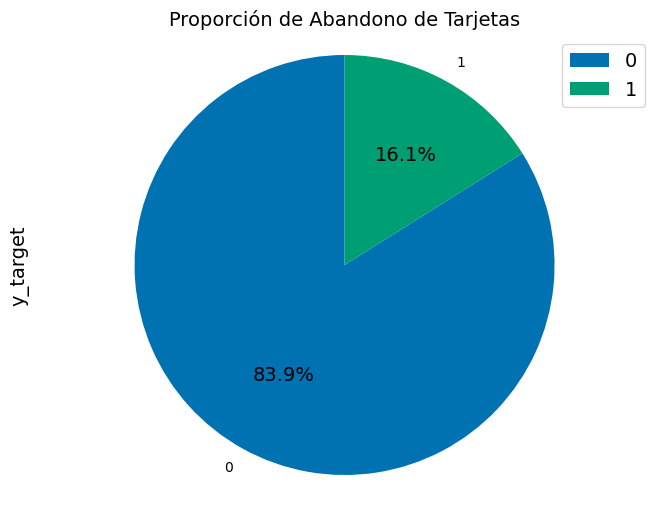

In [73]:
# calcular proporcion de clase y-target
full_train1['y_target'].value_counts()
# calcular proporcion de clases
class_proportions = full_train1['y_target'].value_counts(normalize=True)

# crear pie plot
plt.figure(figsize=(8, 6))
class_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Proporción de Abandono de Tarjetas')
plt.legend(labels=full_train1['y_target'].unique().tolist(), loc='best')
plt.axis('equal')

# Show the plot
plt.show()

## Técnicas de Correlación

### Correlación de Pearson (Lineal)

In [74]:
pearson_corr = full_train1.corr(method='pearson')


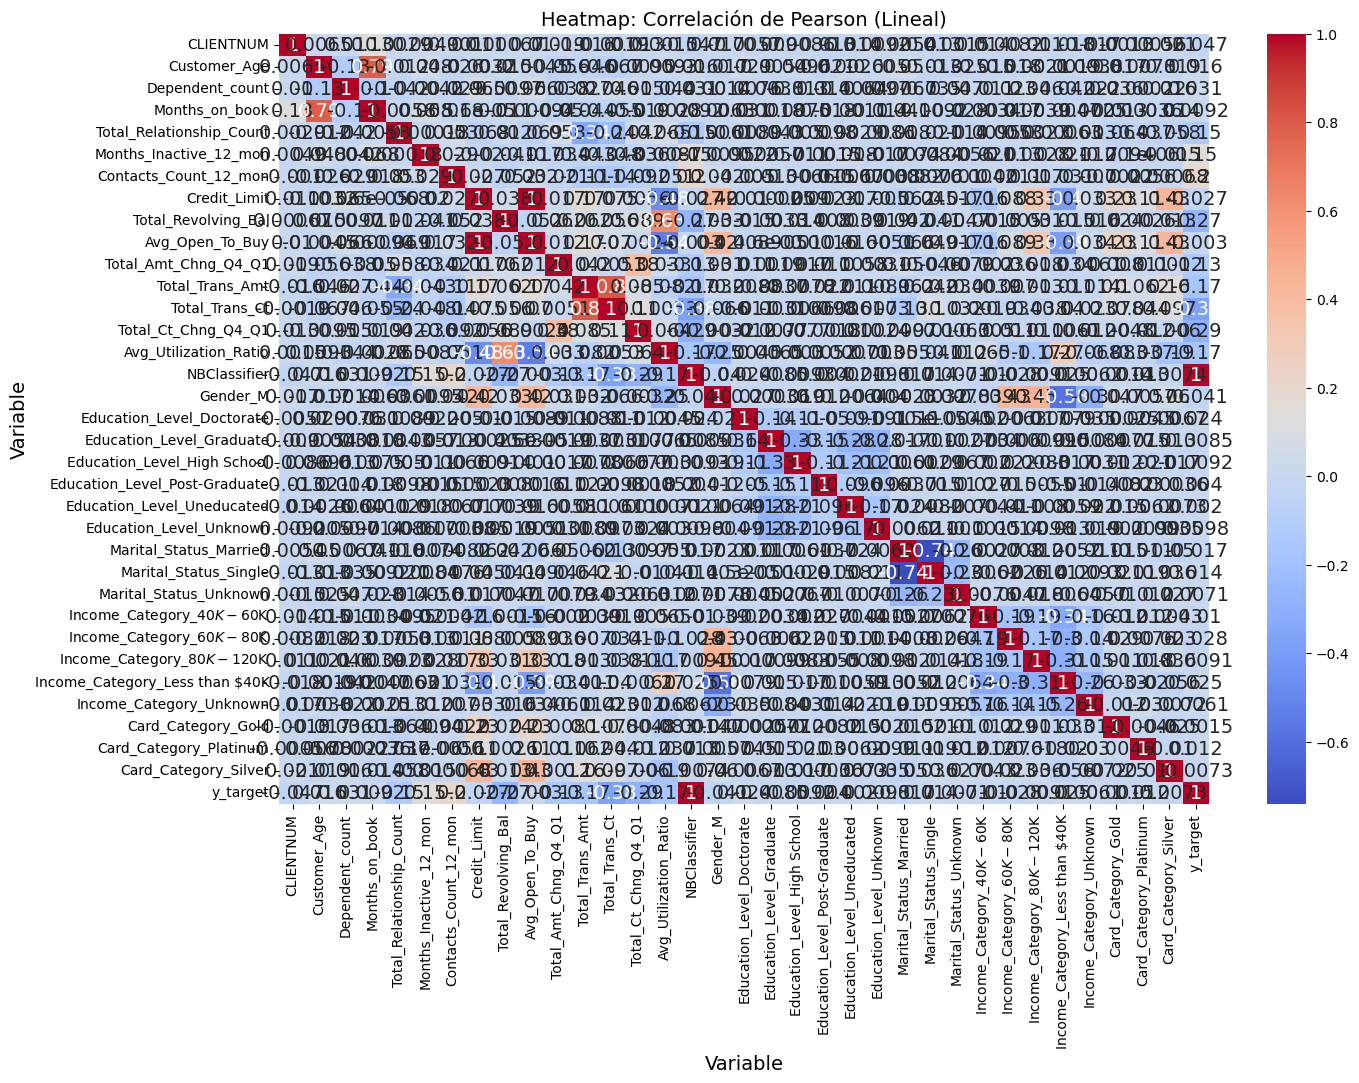

In [75]:
# Plot the covariance matrix heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(full_train1.corr(method='pearson'), annot=True, cmap='coolwarm', ax=ax)

# Set the axis labels
plt.xlabel('Variable')
plt.ylabel('Variable')

# Set the plot title
plt.title('Heatmap: Correlación de Pearson (Lineal)')

# Show the plot
plt.show()

### Correlación de Ranking Kendall (Asociaciones Ordinales)

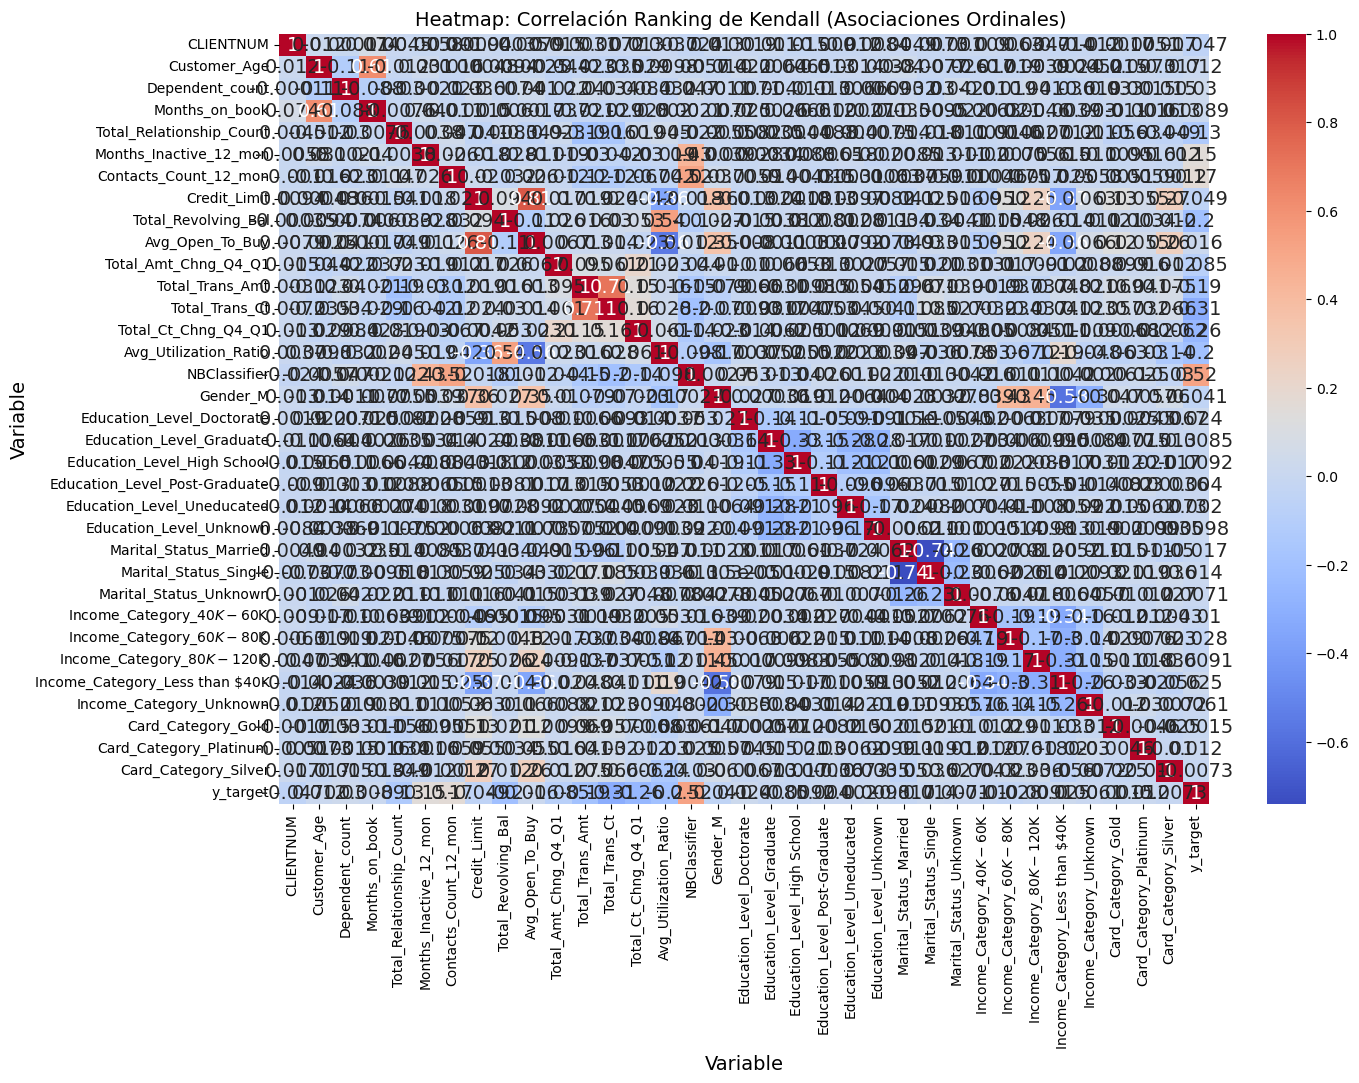

In [76]:
kendall_corr = full_train1.corr(method='kendall')

# Plot the Kendall Ranking matrix heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', ax=ax)

# Set the axis labels
plt.xlabel('Variable')
plt.ylabel('Variable')

# Set the plot title
plt.title('Heatmap: Correlación Ranking de Kendall (Asociaciones Ordinales) ')

# Show the plot
plt.show()

### Matriz de Correlación

In [77]:
# crear matriz de correlación entre variables numericas en base de datos 
corr_matrix =full_train1.corr()
corr_matrix

CLIENTNUM  Customer_Age  Dependent_count  \
CLIENTNUM                        1.000000      0.006498         0.010440   
Customer_Age                     0.006498      1.000000        -0.126841   
Dependent_count                  0.010440     -0.126841         1.000000   
Months_on_book                   0.131287      0.789177        -0.102341   
Total_Relationship_Count         0.002852     -0.012418        -0.041682   
Months_Inactive_12_mon           0.004910      0.047937        -0.004193   
Contacts_Count_12_mon           -0.001037     -0.025649        -0.029130   
Credit_Limit                     0.010511     -0.003161         0.065421   
Total_Revolving_Bal              0.000673      0.014800        -0.009717   
Avg_Open_To_Buy                  0.010444     -0.004492         0.066255   
Total_Amt_Chng_Q4_Q1             0.018566     -0.055993        -0.038248   
Total_Trans_Amt                 -0.016350     -0.045891         0.027348   
Total_Trans_Ct                  -0.001856     -0.067159         0.046066   
Total_Ct_Chng_Q4_Q1              0.013139     -0.009482         0.015466   
Avg_Utilization_Ratio            0.001531      0.009318        -0.044359   
NBClassifier                    -0.046528      0.015849         0.030934   
Gender_M                         0.017296     -0.016998         0.001431   
Education_Level_Doctorate       -0.005717      0.029258        -0.007637   
Education_Level_Graduate         0.009025     -0.005379         0.003784   
Education_Level_High School     -0.008581      0.009629        -0.012941   
Education_Level_Post-Graduate   -0.012632     -0.021470         0.013683   
Education_Level_Uneducated      -0.013988      0.002618        -0.006367   
Education_Level_Unknown          0.009209     -0.005037         0.009651   
Marital_Status_Married           0.005414      0.049542         0.006743   
Marital_Status_Single           -0.012907     -0.012512        -0.035110   
Marital_Status_Unknown           0.001533     -0.025388         0.046548   
Income_Category_$40K - $60K      0.013603     -0.014775        -0.011289   
Income_Category_$60K - $80K      0.008165     -0.017703         0.022896   
Income_Category_$80K - $120K     0.011051      0.002074         0.046136   
Income_Category_Less than $40K  -0.017709     -0.001908        -0.042397   
Income_Category_Unknown         -0.016968      0.003754        -0.021898   
Card_Category_Gold              -0.001311     -0.017349         0.035517   
Card_Category_Platinum          -0.000561      0.007753        -0.000218   
Card_Category_Silver             0.021329     -0.019161         0.015976   
y_target                        -0.046578      0.015827         0.030708   

                                Months_on_book  Total_Relationship_Count  \
CLIENTNUM                             0.131287                  0.002852   
Customer_Age                          0.789177                 -0.012418   
Dependent_count                      -0.102341                 -0.041682   
Months_on_book                        1.000000                 -0.005842   
Total_Relationship_Count             -0.005842                  1.000000   
Months_Inactive_12_mon                0.067710                 -0.000178   
Contacts_Count_12_mon                -0.017750                  0.053185   
Credit_Limit                          0.000056                 -0.068232   
Total_Revolving_Bal                   0.011089                  0.011697   
Avg_Open_To_Buy                      -0.000942                 -0.069242   
Total_Amt_Chng_Q4_Q1                 -0.049687                  0.057613   
Total_Trans_Amt                      -0.043890                 -0.341138   
Total_Trans_Ct                       -0.055009                 -0.235131   
Total_Ct_Chng_Q4_Q1                  -0.018568                  0.041531   
Avg_Utilization_Ratio                -0.002759                  0.065461   
NBClassifier                          0.009241                 -0.145082   
Gen

### Pairplot

In [ ]:
#sns.pairplot(full_train1, diag_kind="hist", kind='scatter', hue='y_target', palette=['blue','red'])

### Matriz de Covarianza

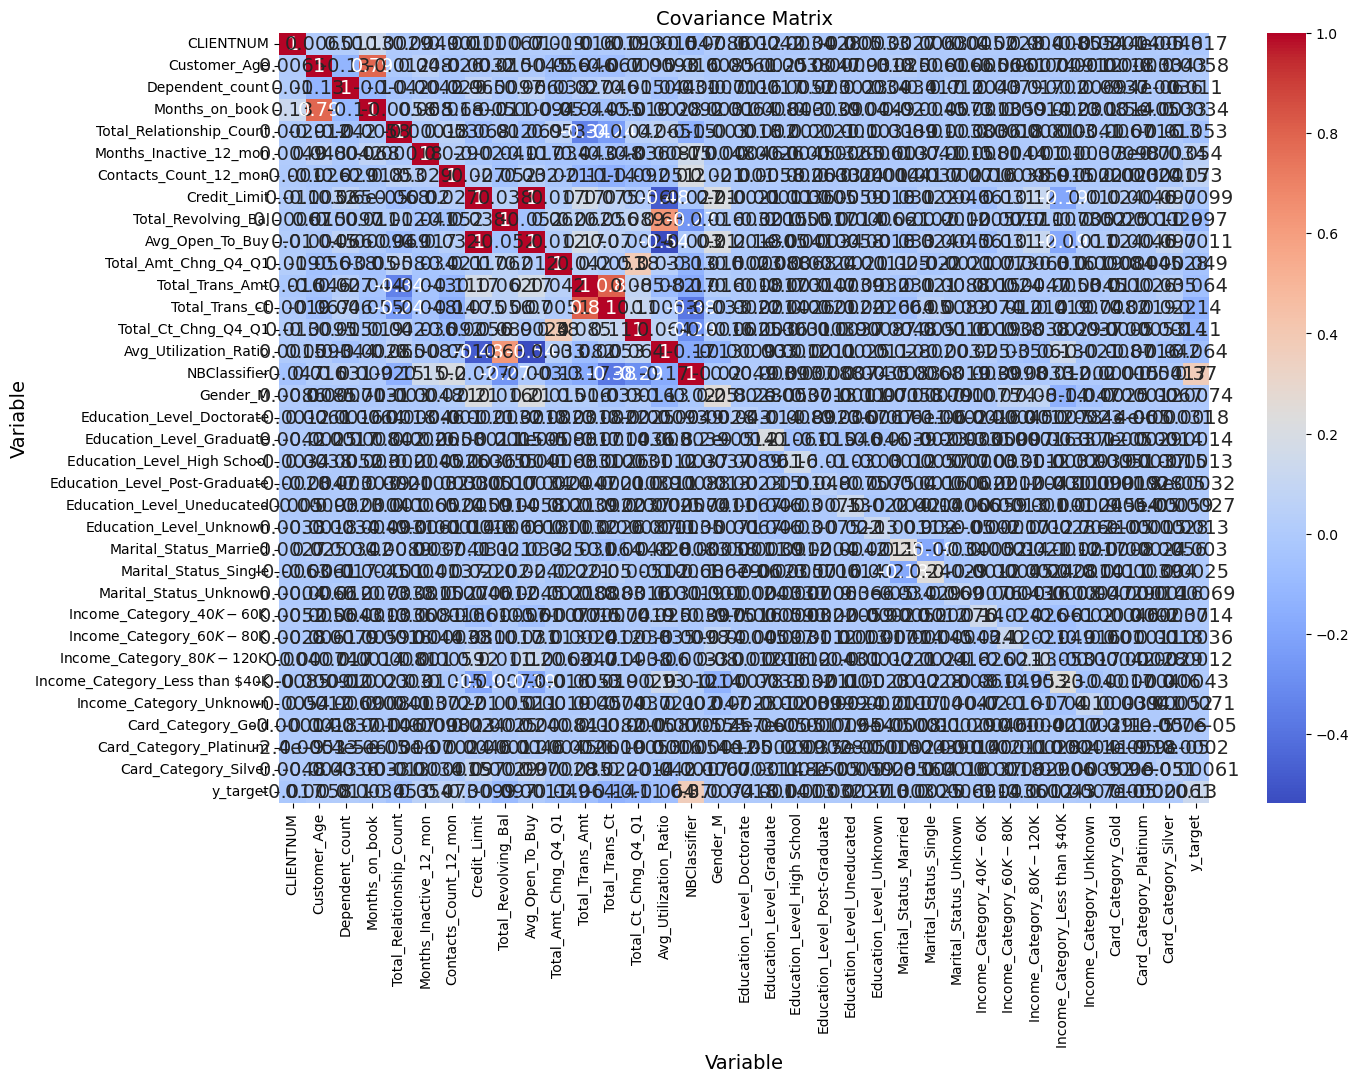

In [78]:
# Calculate the covariance matrix
covariance_matrix = full_train1.cov()

# Plot the covariance matrix heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', ax=ax)

# Set the axis labels
plt.xlabel('Variable')
plt.ylabel('Variable')

# Set the plot title
plt.title('Covariance Matrix')

# Show the plot
plt.show()

In [79]:
# correlación con 'variable ' especifica target
corr_matrix["y_target"].sort_values(ascending=False)

y_target                          1.000000
NBClassifier                      0.999989
Contacts_Count_12_mon             0.199495
Months_Inactive_12_mon            0.147070
Dependent_count                   0.030708
Income_Category_Less than $40K    0.024813
Education_Level_Doctorate         0.023522
Customer_Age                      0.015827
Marital_Status_Single             0.013865
Card_Category_Platinum            0.012424
Education_Level_Unknown           0.009758
Months_on_book                    0.009207
Marital_Status_Unknown            0.007145
Income_Category_Unknown           0.006134
Education_Level_Post-Graduate     0.003980
Education_Level_Uneducated        0.002050
Card_Category_Gold               -0.001491
Avg_Open_To_Buy                  -0.003024
Card_Category_Silver             -0.007326
Education_Level_Graduate         -0.008503
Income_Category_$80K - $120K     -0.009124
Education_Level_High School      -0.009196
Income_Category_$40K - $60K      -0.010249
Marital_Sta

# Machine Learning